# Analyzing Franz Kafka's _The Metamorphosis_ with NLP

* Kafka's _Metamorphosis_ is commonly interpreted by humans as giving insights into the meaning of personal identity
* The conclusions that we can draw from texts are limited by our uniquely human preconceptions and rhetorical weaknesses
* Guiding question: What happens when computers read philosophy? That is, if we apply machine learning and linguistic approaches from NLP to analyzing _The Metamorphosis_, how will the results support or contrast with our human reading?
* Read on to see what computers think about Kafka...

In [66]:
import nltk
import numpy as np
import regex as re
import pandas as pd
from matplotlib import pyplot as plt

The text is sourced from Project Gutenberg (David Wyllie
 translation): http://www.gutenberg.org/files/5200/5200-h/5200-h.htm

In [67]:
file = open("5200-h.txt", "r")
content = file.read()

In [68]:
words = re.findall(r"[\w']+", content)

In [69]:
len(words)

22055

In [70]:
def word_freqs(words):
    freqs = {}
    for word in words:
        if word in freqs:
            freqs[word] += 1
        else:
            freqs[word] = 1
    return freqs

In [71]:
word_freqs = word_freqs(words)

In [72]:
word_freqs_to_cols = {'word':list(word_freqs.keys()), 'count':list(word_freqs.values())}
word_freqs_df = pd.DataFrame.from_dict(word_freqs_to_cols)

In [73]:
word_freqs_df.sort_values(by='count', ascending=False, inplace=True)

In [75]:
word_freqs_df.reset_index(drop=True).nlargest(50, 'count')

,count,word
0,1097,the
1,753,to
2,612,and
3,524,his
4,495,he
5,429,of
6,406,was
7,350,had
8,339,in
9,324,that


In [82]:
gregor_indices = [i for i,x in enumerate(words) if x == 'Gregor']

In [108]:
gregor_over_time = {}
j=0
for i in range(0, len(words), 100):
    gregor_over_time[i] = 0
    while j<len(gregor_indices) and gregor_indices[j] < i:
        gregor_over_time[i] += 1
        j+=1

In [106]:
gregor_over_time

{0: 0,
 100: 1,
 200: 1,
 300: 0,
 400: 0,
 500: 0,
 600: 0,
 700: 0,
 800: 0,
 900: 0,
 1000: 1,
 1100: 3,
 1200: 1,
 1300: 7,
 1400: 2,
 1500: 0,
 1600: 0,
 1700: 1,
 1800: 0,
 1900: 0,
 2000: 0,
 2100: 0,
 2200: 0,
 2300: 1,
 2400: 0,
 2500: 2,
 2600: 1,
 2700: 0,
 2800: 1,
 2900: 3,
 3000: 1,
 3100: 2,
 3200: 1,
 3300: 1,
 3400: 3,
 3500: 0,
 3600: 0,
 3700: 0,
 3800: 1,
 3900: 0,
 4000: 1,
 4100: 0,
 4200: 0,
 4300: 2,
 4400: 1,
 4500: 0,
 4600: 1,
 4700: 1,
 4800: 1,
 4900: 0,
 5000: 0,
 5100: 3,
 5200: 0,
 5300: 1,
 5400: 1,
 5500: 0,
 5600: 0,
 5700: 1,
 5800: 1,
 5900: 3,
 6000: 3,
 6100: 1,
 6200: 0,
 6300: 2,
 6400: 2,
 6500: 1,
 6600: 1,
 6700: 2,
 6800: 1,
 6900: 1,
 7000: 5,
 7100: 1,
 7200: 1,
 7300: 1,
 7400: 0,
 7500: 1,
 7600: 1,
 7700: 1,
 7800: 2,
 7900: 0,
 8000: 0,
 8100: 1,
 8200: 1,
 8300: 0,
 8400: 1,
 8500: 2,
 8600: 0,
 8700: 0,
 8800: 0,
 8900: 2,
 9000: 1,
 9100: 2,
 9200: 0,
 9300: 0,
 9400: 1,
 9500: 1,
 9600: 2,
 9700: 2,
 9800: 2,
 9900: 1,
 10000: 1,
 

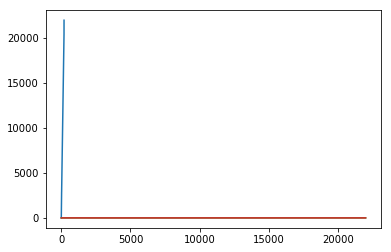

In [111]:
plt.plot(list(gregor_over_time.keys()), list(gregor_over_time.values()))
plt.show()